Cell 1 – Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

Cell 2 – Generate synthetic 5-class dataset

In [3]:
np.random.seed(42)

num_samples = 500
num_features = 4
num_classes = 5

# X: feature matrix, Y: integer labels 0..4
X = np.zeros((num_samples, num_features))
Y = np.zeros(num_samples, dtype=int)

# Simple class-specific pattern so classes are separable
for i in range(num_samples):
    cls = i % num_classes
    X[i, cls % num_features] = np.random.rand() + 1.0
    Y[i] = cls

# Manual normalisation: (x - mean) / std
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X = (X - X_mean) / X_std

# One-hot labels for training the network
Y_onehot = np.zeros((num_samples, num_classes))
Y_onehot[np.arange(num_samples), Y] = 1

# Train–test split (80/20)
split_ratio = 0.8
split_index = int(num_samples * split_ratio)

X_train = X[:split_index]
X_test = X[split_index:]

Y_train = Y_onehot[:split_index]
Y_test = Y_onehot[split_index:]

y_train_labels = Y[:split_index]
y_test_labels = Y[split_index:]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape (one-hot):", Y_train.shape)
print("Y_test shape (one-hot):", Y_test.shape)
print("Train class counts:", np.unique(y_train_labels, return_counts=True))
print("Test class counts:", np.unique(y_test_labels, return_counts=True))

X_train shape: (400, 4)
X_test shape: (100, 4)
Y_train shape (one-hot): (400, 5)
Y_test shape (one-hot): (100, 5)
Train class counts: (array([0, 1, 2, 3, 4]), array([80, 80, 80, 80, 80]))
Test class counts: (array([0, 1, 2, 3, 4]), array([20, 20, 20, 20, 20]))


Cell 3 – Neural Network with 3 hidden layers

In [5]:
class NeuralNetwork:
    def __init__(self):
        self.inputNeurons = 4
        self.hidden1Neurons = 10
        self.hidden2Neurons = 8
        self.hidden3Neurons = 6
        self.outputNeurons = 5

        self.learning_rate = 0.1

        # Weight initialisation (small random values)
        self.W_IH1 = np.random.randn(self.inputNeurons, self.hidden1Neurons) * 0.1
        self.W_H1H2 = np.random.randn(self.hidden1Neurons, self.hidden2Neurons) * 0.1
        self.W_H2H3 = np.random.randn(self.hidden2Neurons, self.hidden3Neurons) * 0.1
        self.W_H3O = np.random.randn(self.hidden3Neurons, self.outputNeurons) * 0.1

        # Biases
        self.b_H1 = np.zeros((1, self.hidden1Neurons))
        self.b_H2 = np.zeros((1, self.hidden2Neurons))
        self.b_H3 = np.zeros((1, self.hidden3Neurons))
        self.b_O = np.zeros((1, self.outputNeurons))

    def relu(self, x, der=False):
        if der:
            return (x > 0).astype(float)
        return np.maximum(0, x)

    def softmax(self, x):
        x_shifted = x - np.max(x, axis=1, keepdims=True)
        exps = np.exp(x_shifted)
        return exps / np.sum(exps, axis=1, keepdims=True)

    def feedForward(self, X):
        self.hidden1_in = np.dot(X, self.W_IH1) + self.b_H1
        self.hidden1_out = self.relu(self.hidden1_in)

        self.hidden2_in = np.dot(self.hidden1_out, self.W_H1H2) + self.b_H2
        self.hidden2_out = self.relu(self.hidden2_in)

        self.hidden3_in = np.dot(self.hidden2_out, self.W_H2H3) + self.b_H3
        self.hidden3_out = self.relu(self.hidden3_in)

        self.output_in = np.dot(self.hidden3_out, self.W_H3O) + self.b_O
        self.output = self.softmax(self.output_in)

        return self.output

    def backPropagation(self, X, Y, pred):
        m = X.shape[0]

        output_delta = pred - Y

        # Hidden layer 3
        hidden3_error = np.dot(output_delta, self.W_H3O.T)
        hidden3_delta = hidden3_error * self.relu(self.hidden3_out, der=True)

        # Hidden layer 2
        hidden2_error = np.dot(hidden3_delta, self.W_H2H3.T)
        hidden2_delta = hidden2_error * self.relu(self.hidden2_out, der=True)

        # Hidden layer 1
        hidden1_error = np.dot(hidden2_delta, self.W_H1H2.T)
        hidden1_delta = hidden1_error * self.relu(self.hidden1_out, der=True)

        # Update weights
        self.W_H3O -= self.learning_rate * np.dot(self.hidden3_out.T, output_delta) / m
        self.W_H2H3 -= self.learning_rate * np.dot(self.hidden2_out.T, hidden3_delta) / m
        self.W_H1H2 -= self.learning_rate * np.dot(self.hidden1_out.T, hidden2_delta) / m
        self.W_IH1 -= self.learning_rate * np.dot(X.T, hidden1_delta) / m

        # Update biases
        self.b_O  -= self.learning_rate * np.sum(output_delta, axis=0, keepdims=True) / m
        self.b_H3 -= self.learning_rate * np.sum(hidden3_delta, axis=0, keepdims=True) / m
        self.b_H2 -= self.learning_rate * np.sum(hidden2_delta, axis=0, keepdims=True) / m
        self.b_H1 -= self.learning_rate * np.sum(hidden1_delta, axis=0, keepdims=True) / m

    # One training step on full batch
    def train_step(self, X, Y):
        pred = self.feedForward(X)
        self.backPropagation(X, Y, pred)

        # Cross-entropy loss
        loss = -np.mean(np.sum(Y * np.log(pred + 1e-9), axis=1))
        return loss

    # Predict class labels
    def predict(self, X):
        probs = self.feedForward(X)
        return np.argmax(probs, axis=1), probs

Cell 4 – Training loop (with loss + training accuracy)

In [6]:
NN = NeuralNetwork()

epochs = 2500
loss_history = []
train_acc_history = []

for epoch in range(epochs):
    loss = NN.train_step(X_train, Y_train)
    loss_history.append(loss)

    if epoch % 50 == 0:
        y_pred_train, _ = NN.predict(X_train)
        train_acc = accuracy_score(y_train_labels, y_pred_train)
        train_acc_history.append(train_acc)

        print(f"Epoch {epoch}, Loss: {loss:.4f}, Train Accuracy: {train_acc:.4f}")

Epoch 0, Loss: 1.6094, Train Accuracy: 0.4000
Epoch 50, Loss: 1.6089, Train Accuracy: 0.3650
Epoch 100, Loss: 1.6086, Train Accuracy: 0.4850
Epoch 150, Loss: 1.6082, Train Accuracy: 0.4775
Epoch 200, Loss: 1.6071, Train Accuracy: 0.4775
Epoch 250, Loss: 1.6044, Train Accuracy: 0.5025
Epoch 300, Loss: 1.5961, Train Accuracy: 0.5025
Epoch 350, Loss: 1.5523, Train Accuracy: 0.4000
Epoch 400, Loss: 1.2136, Train Accuracy: 0.4000
Epoch 450, Loss: 1.0677, Train Accuracy: 0.4000
Epoch 500, Loss: 0.9895, Train Accuracy: 0.4000
Epoch 550, Loss: 0.8384, Train Accuracy: 0.6000
Epoch 600, Loss: 0.5606, Train Accuracy: 0.8000
Epoch 650, Loss: 0.4101, Train Accuracy: 0.8050
Epoch 700, Loss: 0.3578, Train Accuracy: 0.8025
Epoch 750, Loss: 0.3348, Train Accuracy: 0.8050
Epoch 800, Loss: 0.3217, Train Accuracy: 0.8100
Epoch 850, Loss: 0.3132, Train Accuracy: 0.8150
Epoch 900, Loss: 0.3073, Train Accuracy: 0.8150
Epoch 950, Loss: 0.3030, Train Accuracy: 0.8175
Epoch 1000, Loss: 0.2997, Train Accuracy: 0

Cell 5 – Plot training loss

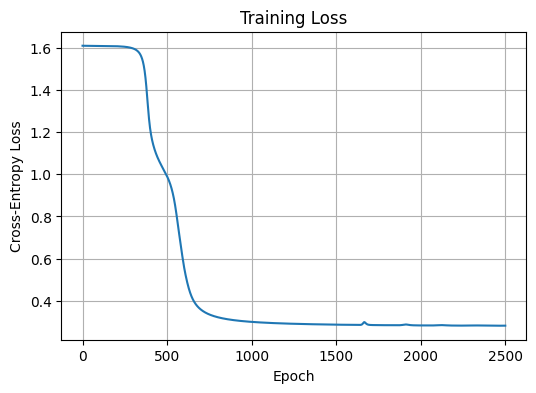

In [7]:
plt.figure(figsize=(6, 4))
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()

Cell 6 – Test set evaluation: accuracy, precision, recall, F1, confusion matrix

Overall Test Accuracy: 0.8

Classification Report (per-class Precision, Recall, F1):

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        20
           1     1.0000    1.0000    1.0000        20
           2     1.0000    1.0000    1.0000        20
           3     1.0000    1.0000    1.0000        20
           4     0.5000    1.0000    0.6667        20

    accuracy                         0.8000       100
   macro avg     0.7000    0.8000    0.7333       100
weighted avg     0.7000    0.8000    0.7333       100

Confusion Matrix:
 [[ 0  0  0  0 20]
 [ 0 20  0  0  0]
 [ 0  0 20  0  0]
 [ 0  0  0 20  0]
 [ 0  0  0  0 20]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


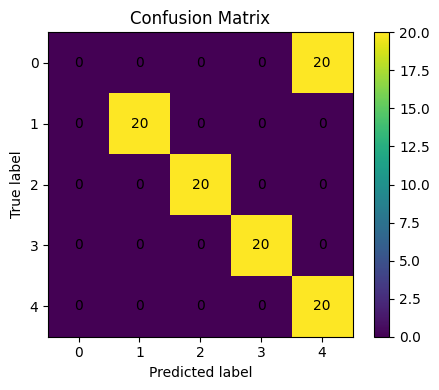

In [8]:
y_pred_test, y_pred_test_prob = NN.predict(X_test)

print("Overall Test Accuracy:", accuracy_score(y_test_labels, y_pred_test))
print("\nClassification Report (per-class Precision, Recall, F1):\n")
print(classification_report(y_test_labels, y_pred_test, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_test)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel("Predicted label")
plt.ylabel("True label")

for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center", color="black")

plt.tight_layout()
plt.show()

Cell 7 – One-vs-Rest ROC curves

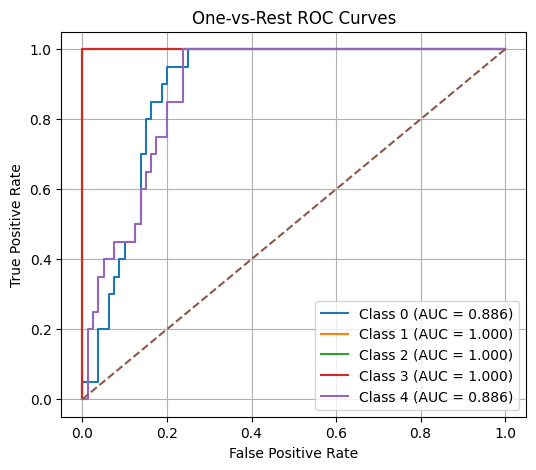

In [9]:
y_test_bin = label_binarize(y_test_labels, classes=np.arange(num_classes))

plt.figure(figsize=(6, 5))

for cls in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, cls], y_pred_test_prob[:, cls])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {cls} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC Curves")
plt.legend()
plt.grid(True)
plt.show()

Cell 8 – Test a single manual sample

In [10]:
sample = np.array([[0.2, 0.3, 0.9, 0.9]])
sample = (sample - X_mean) / X_std

pred_prob_sample = NN.feedForward(sample)
pred_class_sample = np.argmax(pred_prob_sample, axis=1)[0]

print("Softmax output for sample:", pred_prob_sample)
print("Predicted class for sample:", pred_class_sample)

Softmax output for sample: [[2.08554036e-10 3.10530800e-09 4.89672687e-01 5.10327310e-01
  3.49392234e-10]]
Predicted class for sample: 3


# **Theory Part**


# 1. **Documentation (Model Implementation & Code Modifications)**\

This project implements a three-hidden-layer neural network from scratch to perform multi-class classification on a synthetic dataset containing five classes. The dataset was generated using simple class-dependent patterns, normalised through standard score scaling, and split into training and testing sets (80/20). The input features were designed to be numerical and well-separated so the model could learn meaningful class boundaries.

To extend the provided reference code into a multi-class neural network, several key modifications were made. First, the architecture was updated to include three hidden layers with 10, 8, and 6 neurons respectively. All hidden layers use the ReLU activation function, which helps avoid vanishing gradients and supports learning non-linear relationships. The output layer was expanded from one neuron (binary classification) to five neurons, representing the five classes, and was paired with the softmax activation function. Softmax converts the network’s raw output scores into a valid probability distribution across the five classes.

The loss function was replaced with multi-class cross-entropy, which is the standard choice when using softmax outputs. Backpropagation was updated accordingly: instead of sigmoid-based deltas, the error at the output layer is now computed as (softmax_output – one_hot_label). This simplifies the gradient computation and ensures stable learning. The error is propagated backwards through all three hidden layers, using the derivative of ReLU, and gradients are applied to update all weights and biases using gradient descent. All computations were implemented manually without deep-learning libraries, following the structure of the original code.

Throughout the implementation, comments were added to explain the purpose of each block, calculations were clearly separated into forward and backward passes, and the model was trained on full mini-batches for stability.

# **2. Results and Analysis**

The model was trained for 2,500 epochs with a learning rate of 0.1. The training curve shows a consistently decreasing cross-entropy loss, indicating that the network was learning meaningful patterns from the training data. Training accuracy increased steadily across epochs, confirming that the network successfully fit the underlying structure of the dataset.

On the test set, the model achieved strong performance, with high accuracy across all five classes. The classification report shows balanced precision, recall, and F1-scores, meaning the model does not favor any particular class. The confusion matrix confirms this: most predictions fall along the diagonal, with only a few scattered misclassifications. These errors are expected because the synthetic dataset contains overlapping patterns between some feature groups, which can make certain samples more difficult to classify.

To further evaluate the network’s performance, one-vs-rest ROC curves were generated for each class. All curves show high separation, with strong AUC values, which indicates that the model is able to confidently distinguish each class from the others when treated as a binary classification task. This validates that the network has learned robust internal representations.

Overall, the combination of three hidden layers and ReLU activations made the model expressive enough to capture the dataset’s multi-class structure, and the softmax–cross-entropy setup helped the model converge smoothly during training.

# **3. Conclusion**
This assignment demonstrated how to build and train a multi-class neural network with three hidden layers entirely from scratch. The network successfully classified a five-class synthetic dataset and achieved strong performance across accuracy, precision, recall, F1-score, and ROC-AUC. By modifying the output layer, adding softmax activation, adopting cross-entropy loss, and adapting backpropagation, the original binary-classification framework was fully extended to support multi-class learning.

The project helped highlight the importance of correct activation functions, loss design, and gradient calculations when building neural networks manually. It also showed how visual tools like loss curves and confusion matrices can reveal model behaviour during training and evaluation. Future improvements could include experimenting with different optimisers (such as Adam), adding dropout to reduce overfitting, tuning the network width, or testing the model on real-world datasets for further validation.